## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` (Shown) 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 1`: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use Open Clip multi-modal embeddings.
* We will use [Chroma](https://www.trychroma.com/) with support for multi-modal.

A seperate cookbook highlights `Options 2 and 3` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG.ipynb).

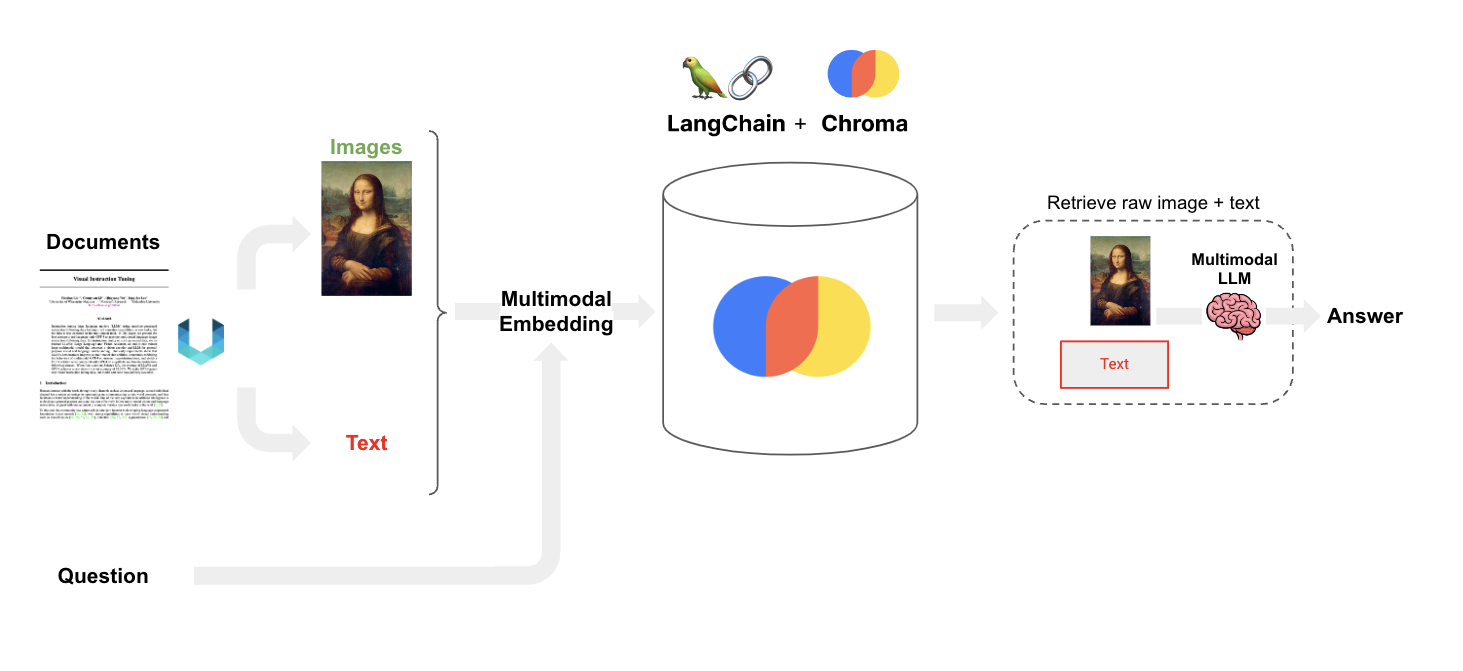

## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install "langchain==0.0.331rc2" # (required for multi-modal)
! pip install "openai==1.1.1" # (required for multi-modal)
! pip install "chromadb==0.4.16" # (required for multi-modal)

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data Loading

### Partition PDF tables, text, and images
  
Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

We use Unstructured to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

Some other interesting documents:

* [Art](https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf)
* [Photography](https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf)

In [36]:
doc_path = "/Users/rlm/Desktop/wildfire_stats/"

In [37]:
from unstructured.partition.pdf import partition_pdf
# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=doc_path + "wildfire_stats.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [39]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings test

We will use [OpenClip embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

In [26]:
# Test
test_path = "/Users/rlm/Desktop/test/"

# Create chroma
vectorstore = Chroma(
    collection_name="test-images",
    embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(test_path, image_name) 
                     for image_name in os.listdir(path) 
                     if image_name.endswith('.jpg')])

image_uris

['/Users/rlm/Desktop/test/animal.jpg',
 '/Users/rlm/Desktop/test/dog.jpg',
 '/Users/rlm/Desktop/test/house.jpg',
 '/Users/rlm/Desktop/test/plane.jpg']

In [ ]:
# Add
vectorstore.add_images(uris=image_uris)

Search on [cosine distance](https://python.langchain.com/docs/integrations/vectorstores/chroma) where lower is better.

In [28]:
docs = vectorstore.similarity_search_with_score("plane")
[d[1] for d in docs]

[1.4335720539093018,
 1.6142889261245728,
 1.6160516738891602,
 1.6747593879699707]

The lowest score is the plane.


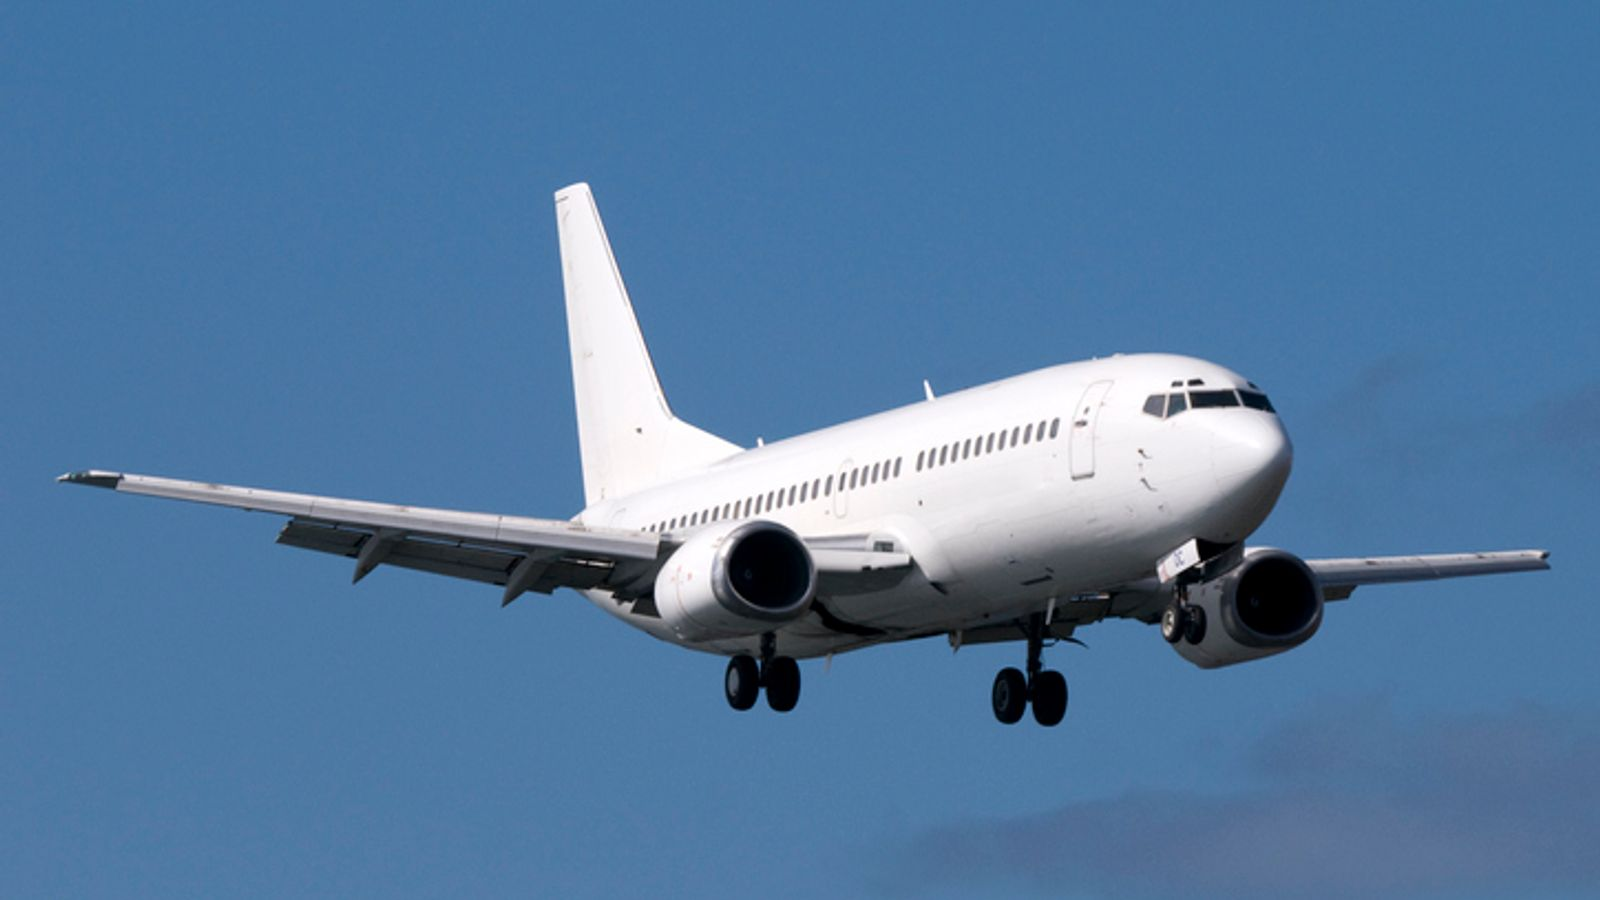

In [29]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

plt_img_base64(docs[0][0].page_content)

## Multi-modal embeddings with our document

In [40]:
import os
import uuid
import chromadb
import numpy as np
from PIL import Image as _PILImage
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenCLIPEmbeddings

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_test",
    embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(doc_path, image_name) 
                     for image_name in os.listdir(path) 
                     if image_name.endswith('.jpg')])
vectorstore.add_images(uris=image_uris)

# Add documents
text_ids = [str(uuid.uuid4()) for _ in texts]
vectorstore.add_texts(texts=texts)
retriever = vectorstore.as_retriever()

In [41]:
# Add a test image of the plane
vectorstore.add_images(uris=["/Users/rlm/Desktop/test/plane.jpg"])

['2884114c-7e9b-11ee-bf12-9e37e47e9d92']

In [46]:
# Cosine search
docs = vectorstore.similarity_search_with_score("airplane")
[d[1] for d in docs]

[0.8741974234580994,
 0.8741974234580994,
 0.9474084377288818,
 0.9474084377288818]

In [47]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    
    # Display the image by rendering the HTML
    display(HTML(image_html))

# We do not recover it
plt_img_base64(docs[0][0].page_content)

In [48]:
docs

[(Document(page_content='Fires, thousands120100Acres burned, millionsFires1210'),
  0.8741974234580994),
 (Document(page_content='Fires, thousands120100Acres burned, millionsFires1210'),
  0.8741974234580994),
 (Document(page_content='Acres burned (millions) Number of Fires'),
  0.9474084377288818),
 (Document(page_content='Acres burned (millions) Number of Fires'),
  0.9474084377288818)]

## RAG

`vectorstore.add_images` will store images as base64 encoded strings, which can be passed to GPT-4V.

In [32]:
import numpy as np
import base64
from io import BytesIO
from PIL import Image

def is_base64(s):
    ''' Check if a string is Base64 encoded '''
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False
        
def split_image_text_types(docs):
    ''' Split numpy array images and texts '''
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content # Extract Document contents 
        if is_base64(doc):
            images.append(doc)  # base64 encoded str 
            print("IMG!")
            print(doc)
        else:
            text.append(doc) 
    return {
        "images": images,
        "texts": text
    }

## RAG

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [35]:
from operator import itemgetter
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema.messages import HumanMessage, SystemMessage

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    messages = [
        {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
"""}]

    if dict["context"]["images"]:  # Check if there are any images
        image_message = {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}}
        messages.append(image_message)

    return [HumanMessage(content=messages)]
    
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [38]:
chain.invoke(
    "What is the change in wild fires from 1993 to 2022?"
)

'The provided context does not include specific data on the number of wildfires or acres burned in 1993, so it is not possible to calculate the exact change in wildfires from 1993 to 2022 based on this information alone. Additional data from 1993 would be needed to make this comparison.'